In [68]:
import random

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.options.display.max_columns = 1000

In [74]:
# Latent Dirichlet Allocation (LDA) Model using scikit-learn
catalog_data = pd.read_csv('./datasets/cleaned-catalog.csv')
lo_data = pd.read_csv('./datasets/cleaned-lo-dataset.csv')
job_data = pd.read_csv('./datasets/cleaned-job-descriptions.csv')

catalog_stopwords = nltk.corpus.stopwords.words('english')
job_stopwords = nltk.corpus.stopwords.words('english')
lo_stopwords = nltk.corpus.stopwords.words('english')

# add custom stopwords for course descriptions
catalog_stopwords.extend(['see', 'prerequisite', 'hour', 'hours', 'freshman', 'sophomore', 'junior', 'senior', 'standing', 'credit', 'consent', 'equivalent', 'undergraduate', 'graduate',
                          'may', 'taken', 'course', 'courses', 'students', 'student', 'topics', 'include', 'includes', 'including', 'introduction', 'repeated', 'intended',
                          'su', 'eps', 'instructor', 'section', 'one', 'vary', 'maximum', 'degree', 'program', 'department', 'register', 'per', 'term', 'terms', 'registration',
                          'completed', 'concurrently', 'enrolled', 'enrollment', 'approved', 'letter', 'grading', 'major', 'majors', 'fees', 'apply', 'illinois', 'andor', 'passing'
                          'summer', 'carle', 'concurrent', 'class', 'week', 'semester', 'semesters', 'required', 'using', 'examine', 'examines', 'restricted', 'phase', 'separate',
                          'use', 'departmental', 'approval', 'offered', 'years', 'college', 'must', 'given', 'faculty', 'new', 'prerequisites', 'areas', 'offerings', 'schedule',
                          'part' 'level', 'continuation', 'toward', 'whose', 'additional', 'gpa', 'degrees', 'enables', 'identical', 'except', 'curriculum', 'subject', 'involves',
                          'completion'])
# should add each subject as a stopword since they are mentioned in the descriptions
for subject in catalog_data['Subject'].unique():
    catalog_stopwords.append(subject.lower())

job_stopwords.extend(['new', 'one', 'must', 'job', 'per',
                     'ceo', 'work', 'may', 'pay', 'youll', 'never'])

lo_stopwords.extend(['use', 'using', 'students', 'able', 'skills', 'develop', 'identify', 'understand', 'demonstrate', 'cms', 'en', 'levelappropriate',
                    'ontario', 'explain', 'describe', 'include'])


# Create a vectorizer for LDA
catalog_vectorizer = CountVectorizer(
    stop_words=catalog_stopwords, max_df=0.95, min_df=2)
course_count_data = catalog_vectorizer.fit_transform(
    catalog_data['Description'])

lo_vectorizer = CountVectorizer(stop_words=lo_stopwords, max_df=0.95, min_df=2)
lo_count_data = lo_vectorizer.fit_transform(lo_data['Description'])

job_vectorizer = CountVectorizer(
    stop_words=job_stopwords, max_df=0.95, min_df=2)
job_count_data = job_vectorizer.fit_transform(job_data['job_description'])


n_topics = 20
course_lda = LatentDirichletAllocation(
    n_components=n_topics, topic_word_prior=0.05)
course_lda.fit(course_count_data)

lo_lda = LatentDirichletAllocation(
    n_components=n_topics, topic_word_prior=0.05)
lo_lda.fit(lo_count_data)

job_lda = LatentDirichletAllocation(
    n_components=n_topics, topic_word_prior=0.05)
job_lda.fit(job_count_data)


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\t" + " ".join([feature_names[i]
              for i in topic.argsort()[:-no_top_words - 1:-1]]))


no_top_words = 10
print("Course Topics:\n")
display_topics(
    course_lda, catalog_vectorizer.get_feature_names_out(), no_top_words)
print("\nLO Topics:\n")
display_topics(lo_lda, lo_vectorizer.get_feature_names_out(), no_top_words)
print("\nJob Topics:\n")
display_topics(job_lda, job_vectorizer.get_feature_names_out(), no_top_words)

Course Topics:

Topic 0:
	music applied audition level instruction appropriate prior initial passing performance
Topic 1:
	media information theory writing composition requirement social professional general weather
Topic 2:
	philosophy evolution learning biological human well development ecology groups social
Topic 3:
	theory linear applications systems analysis problems learning methods equations engineering
Topic 4:
	data analysis methods techniques design systems statistical concepts programming models
Topic 5:
	health professional design learn systems research management skills biology physiology
Topic 6:
	research study individual special topic independent engineering professional work member
Topic 7:
	global business water international management cultural conflict formerly foreign national
Topic 8:
	social political health history american issues culture public legal cultural
Topic 9:
	data research professional techniques analysis history present energy power media
Topic 10:
	

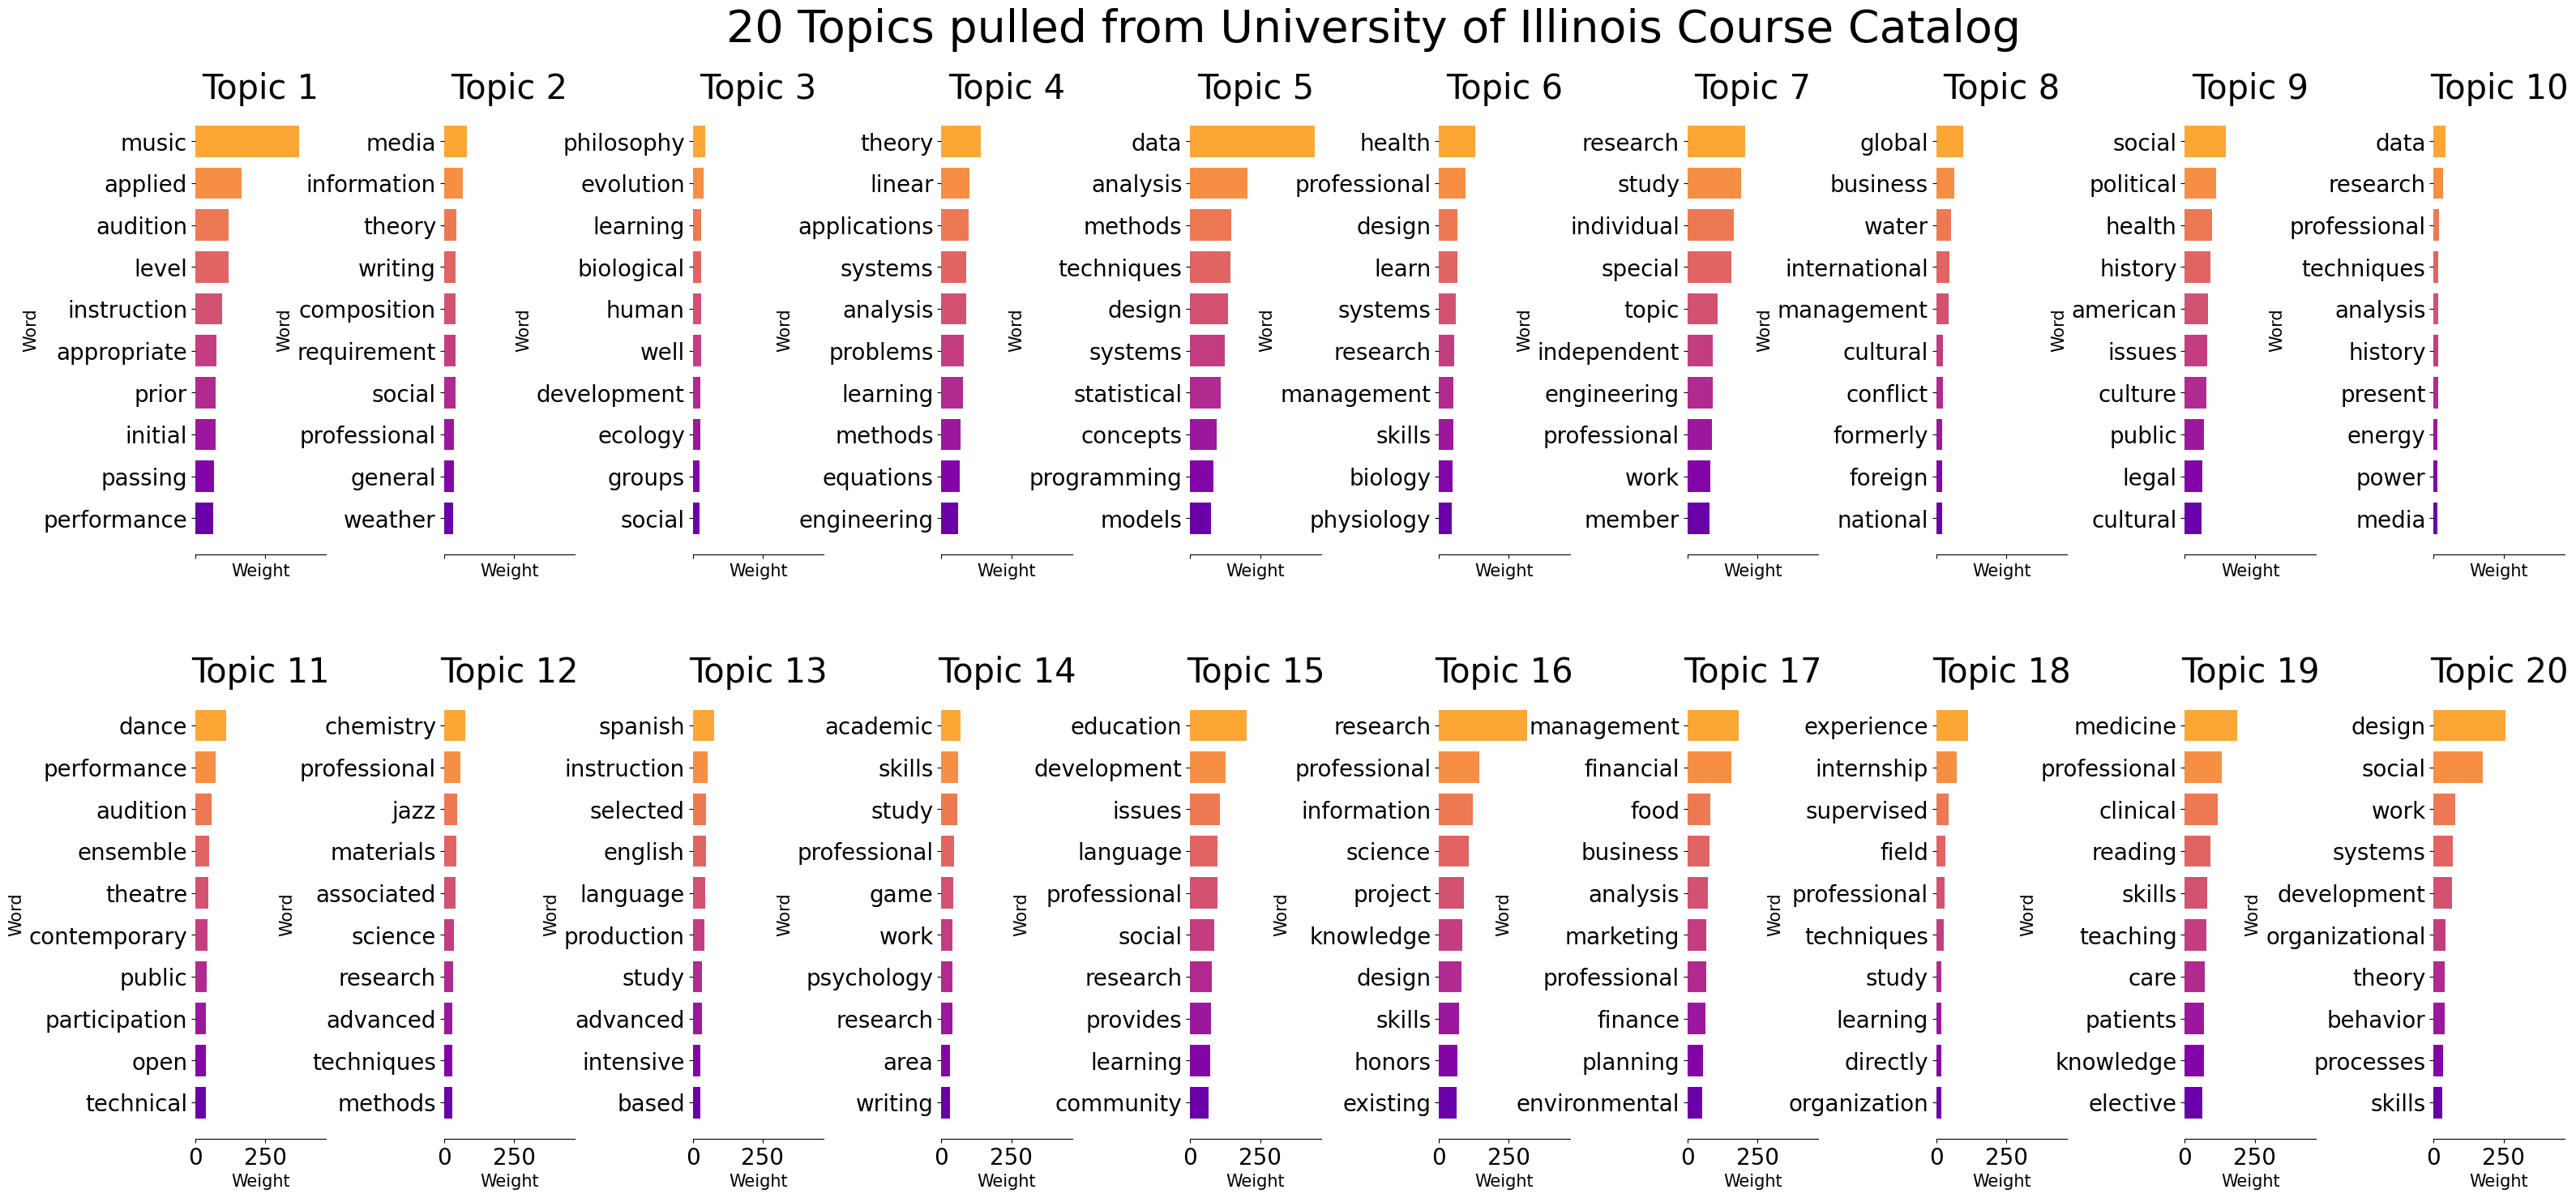

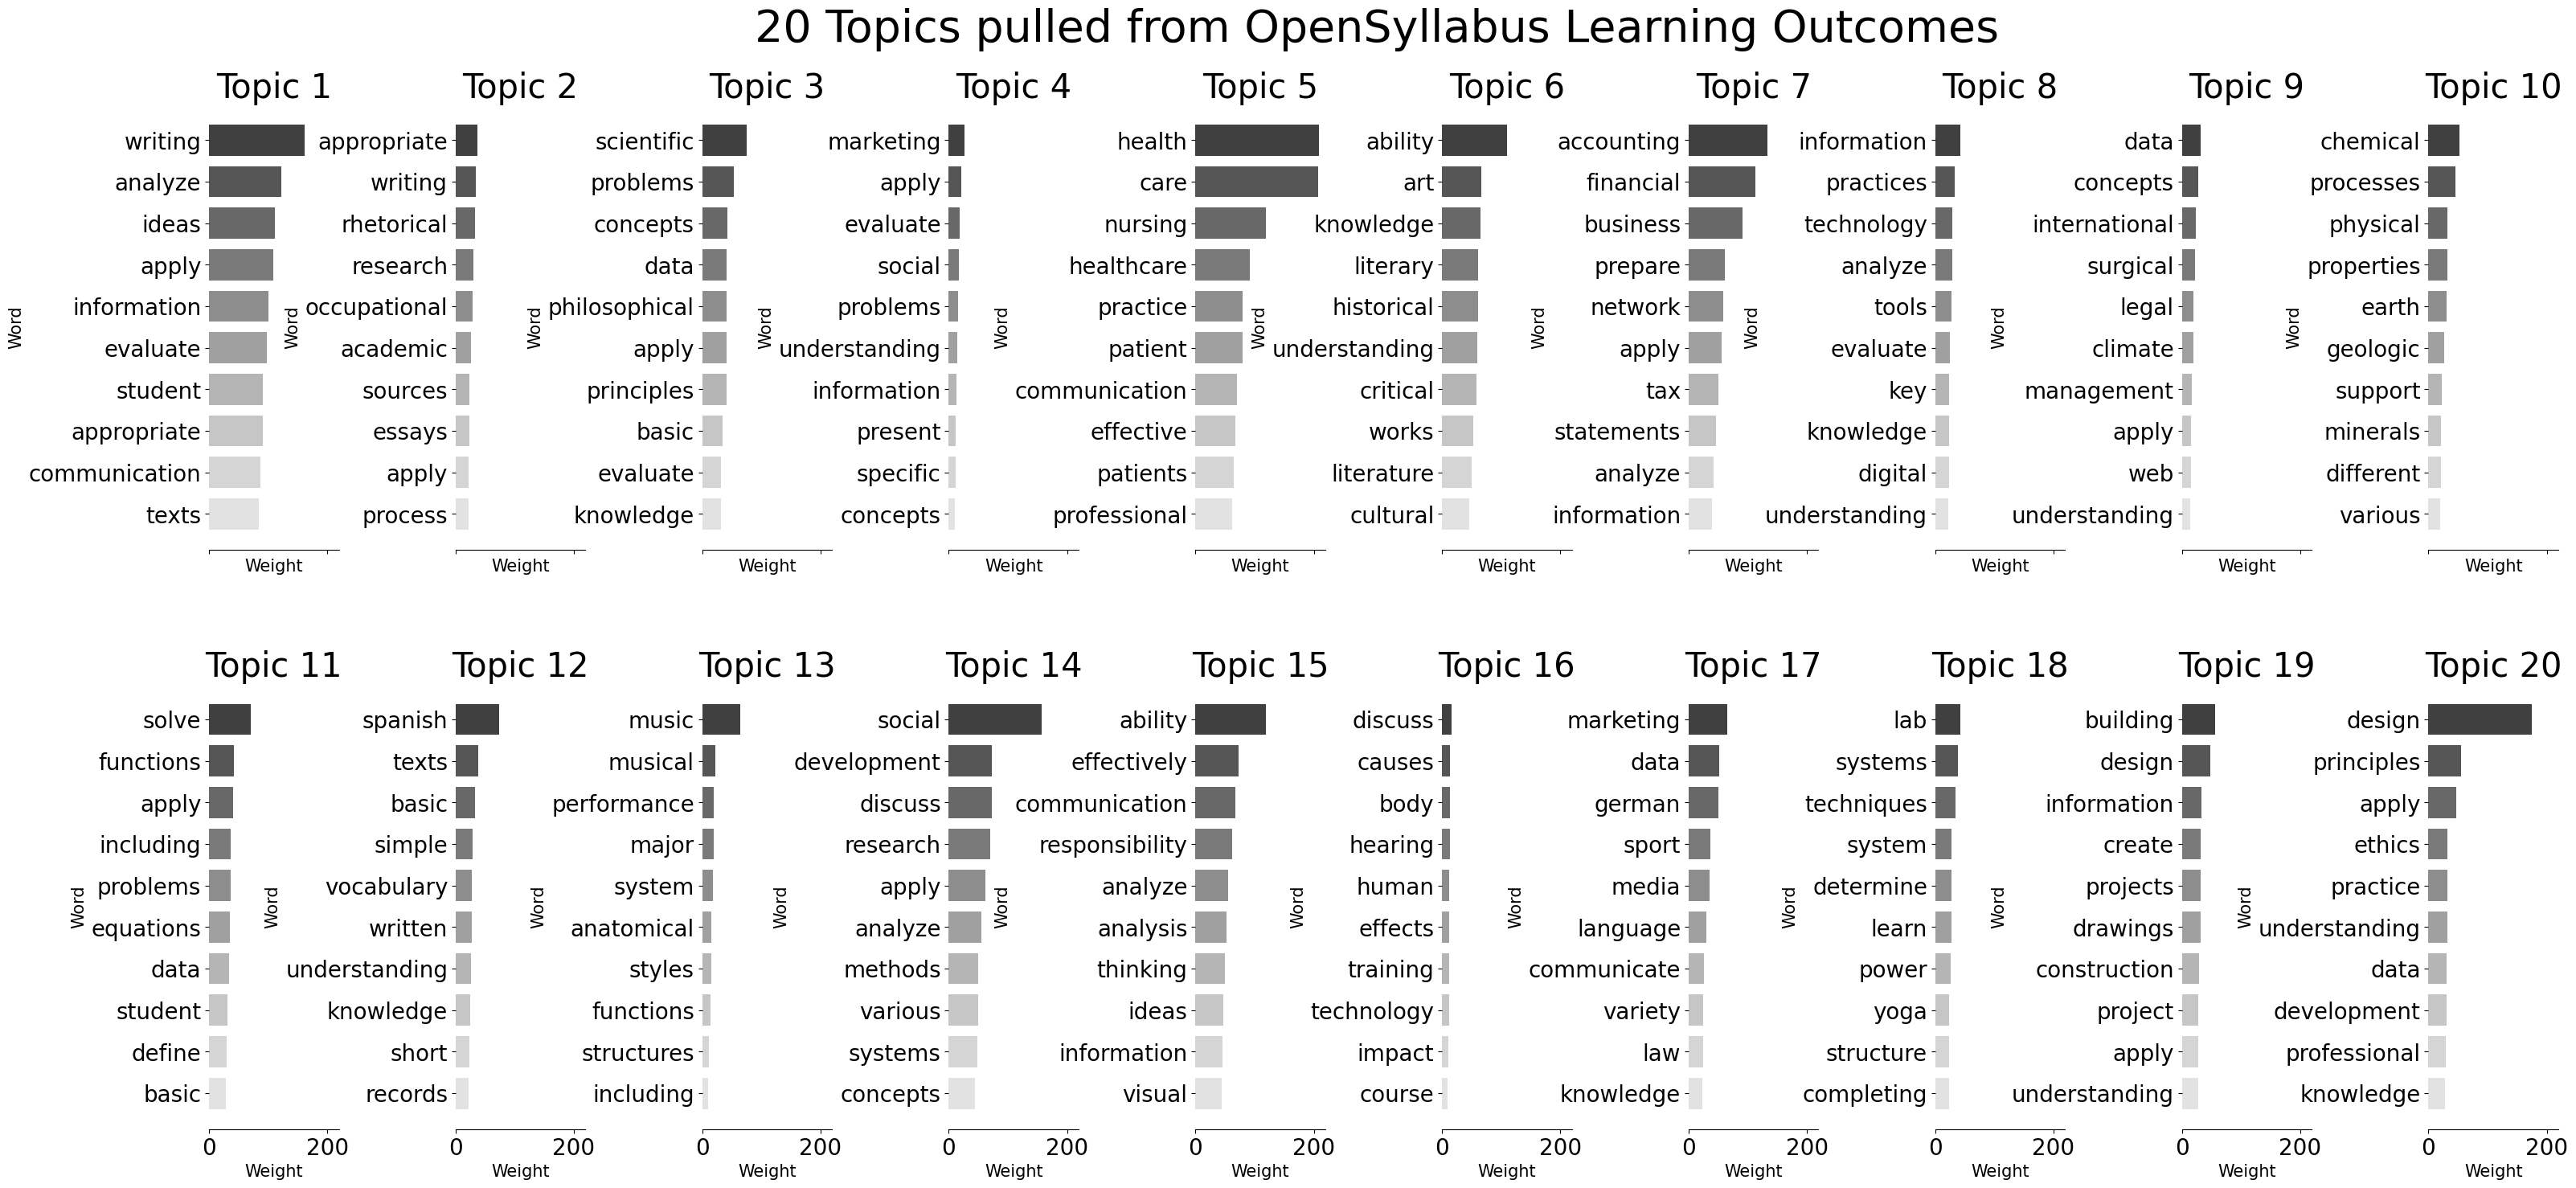

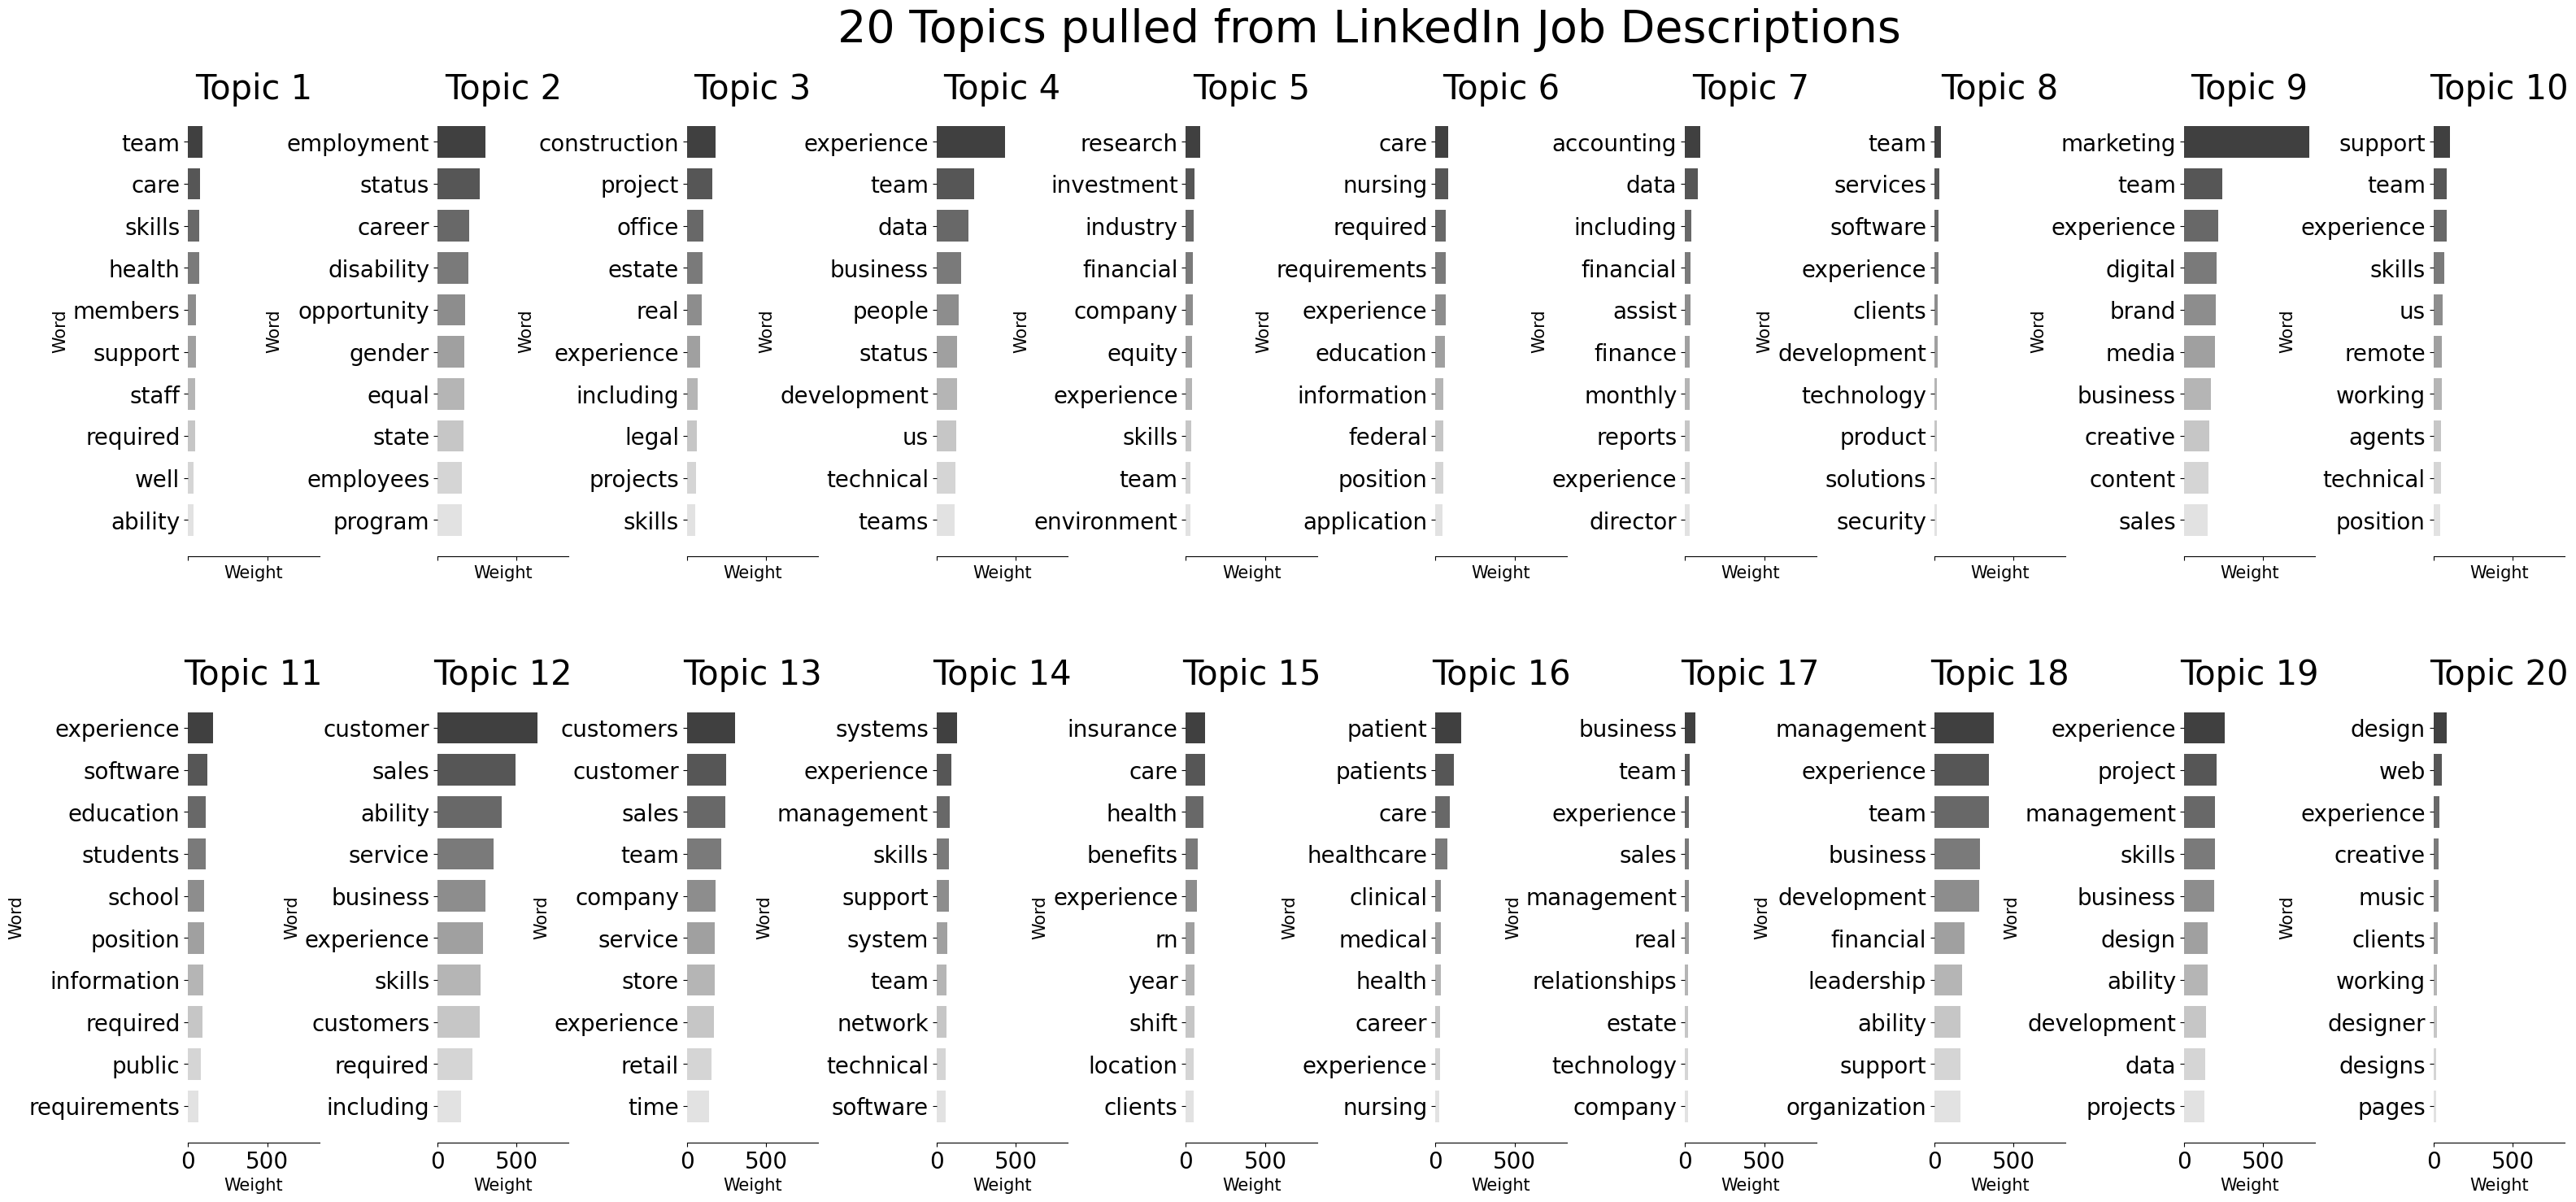

In [76]:
colormaps = ['plasma', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(nrows = 2, ncols= int(n_topics / 2), figsize=(30, 15), sharex=True)
    fig.tight_layout()
    axes = axes.flatten()
    color = random.choice(colormaps)
    colors = plt.get_cmap(color)(np.linspace(0.2, 0.8, n_top_words))

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.75, color=colors)  # Specify the colors for each bar
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    # label x-axis for all plots
    for ax in axes:
        ax.set_xlabel("Weight", fontdict={"fontsize": 15})
        ax.set_ylabel("Word", fontdict={"fontsize": 15})
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


    # Plot the top words for each topic for both the course and job description models
plot_top_words(course_lda, catalog_vectorizer.get_feature_names_out(), no_top_words, f"{n_topics} Topics pulled from University of Illinois Course Catalog")
plot_top_words(lo_lda, lo_vectorizer.get_feature_names_out(), no_top_words, f"{n_topics} Topics pulled from OpenSyllabus Learning Outcomes")
plot_top_words(job_lda, job_vectorizer.get_feature_names_out(), no_top_words, f"{n_topics} Topics pulled from LinkedIn Job Descriptions")

In [71]:
# Load the pre-trained spaCy model with word vectors
nlp = spacy.load("en_core_web_lg")

def get_topic_keywords(lda_model, feature_names, n_top_words=10):
    """
    Extracts the top N words for each topic from an LDA model.
    Args:
    lda_model (LatentDirichletAllocation): The trained LDA model.
    feature_names (list): List of feature names corresponding to the vocabulary.
    n_top_words (int): Number of top words to extract for each topic.
    Returns:
    list of list: A list of lists, where each sublist contains the top N words for a topic.
    """
    top_words = []
    for _, topic in enumerate(lda_model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(top_features)
    return top_words

def get_average_vector(words):
    """
    Computes the average vector for a list of words using spaCy's word vectors.
    Args:
    words (list): List of words to compute the average vector for.
    Returns:
    np.ndarray: The average vector of the input words.
    """
    vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(nlp.vocab.vectors_length)

def topic_labels(top_words_list):
    labels = [', '.join(words) for words in top_words_list]
    return labels

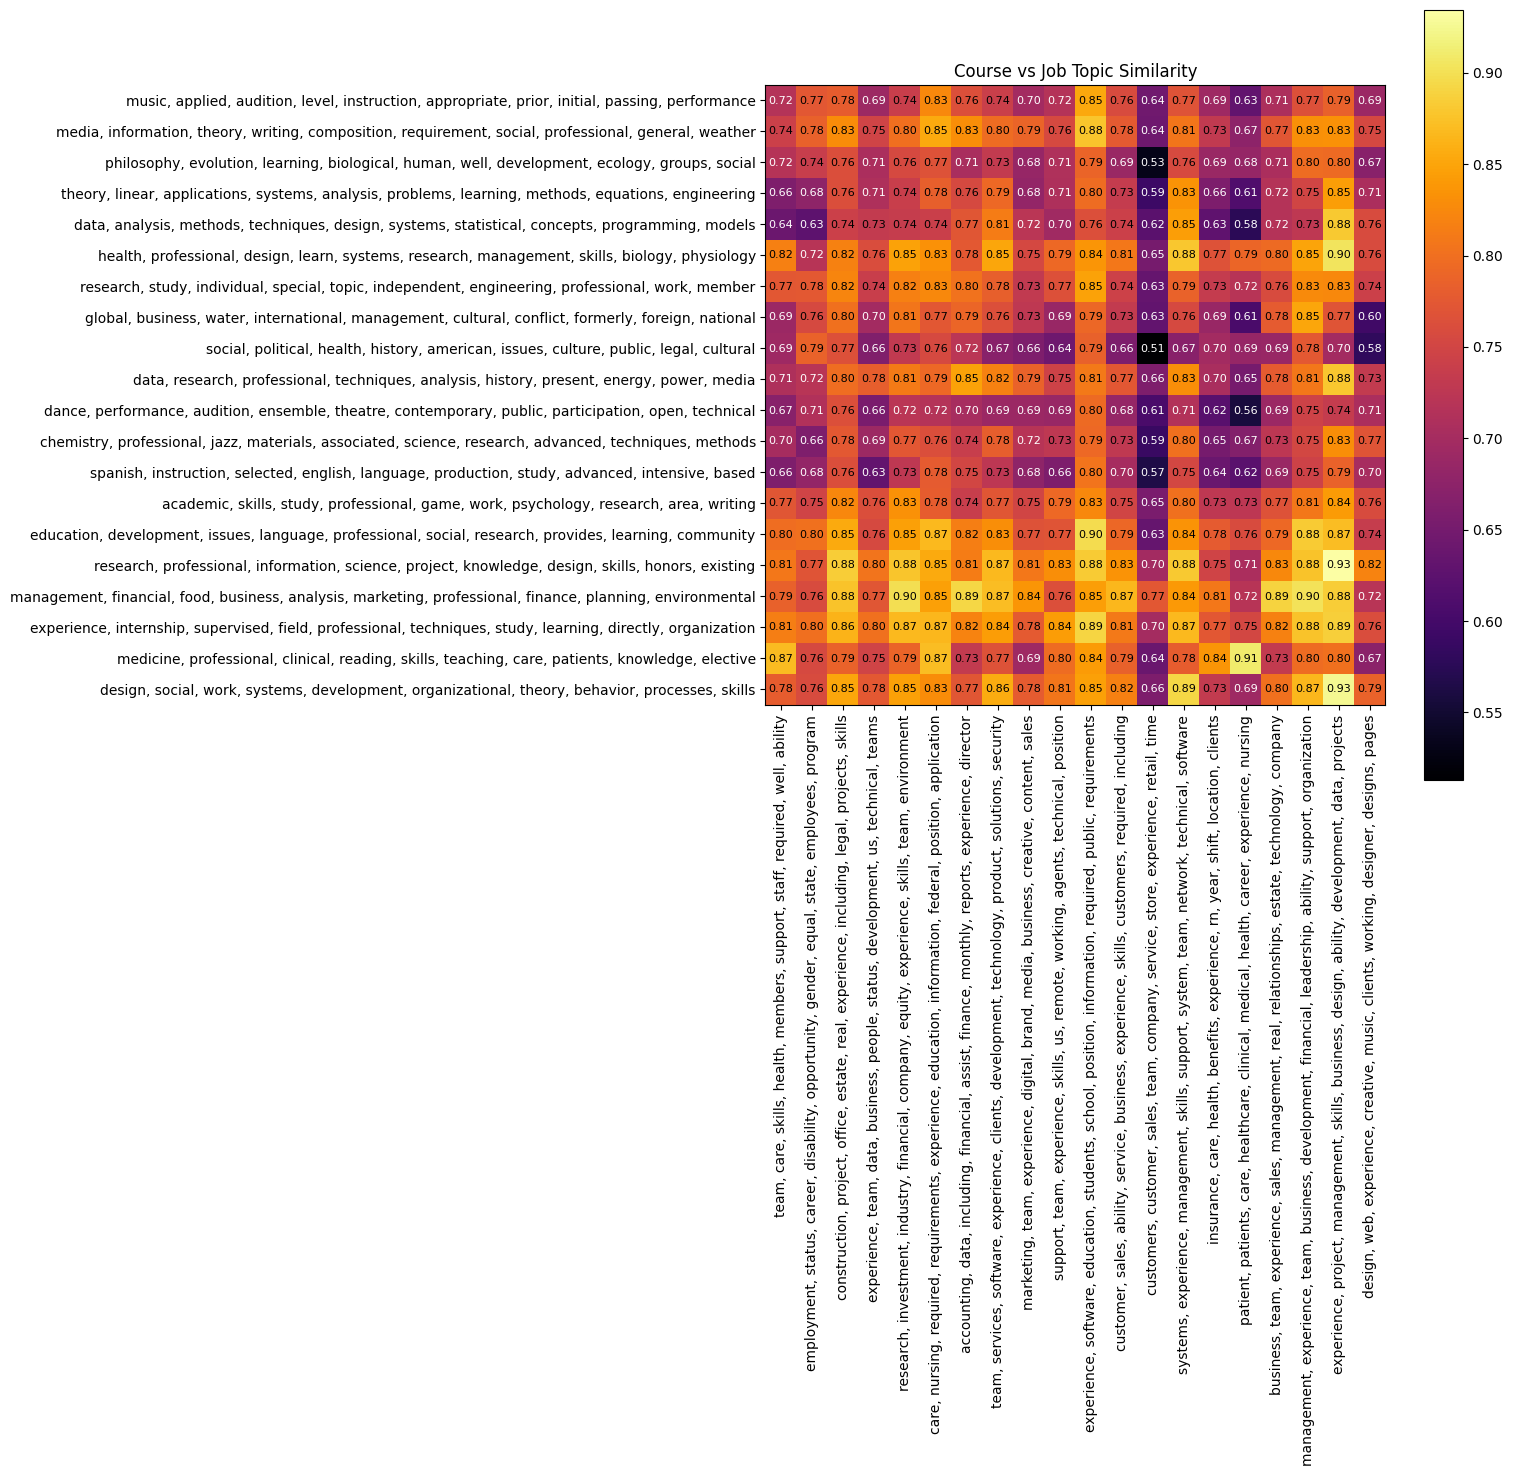

Top 5 Cosine Similarities:
Cosine Similarity: 0.9344391822814941
Course Topic words: research, professional, information, science, project, knowledge, design, skills, honors, existing
Job Topic words: experience, project, management, skills, business, design, ability, development, data, projects
Cosine Similarity: 0.9253106117248535
Course Topic words: design, social, work, systems, development, organizational, theory, behavior, processes, skills
Job Topic words: experience, project, management, skills, business, design, ability, development, data, projects
Cosine Similarity: 0.9102200269699097
Course Topic words: medicine, professional, clinical, reading, skills, teaching, care, patients, knowledge, elective
Job Topic words: patient, patients, care, healthcare, clinical, medical, health, career, experience, nursing
Cosine Similarity: 0.9040641188621521
Course Topic words: health, professional, design, learn, systems, research, management, skills, biology, physiology
Job Topic words: e

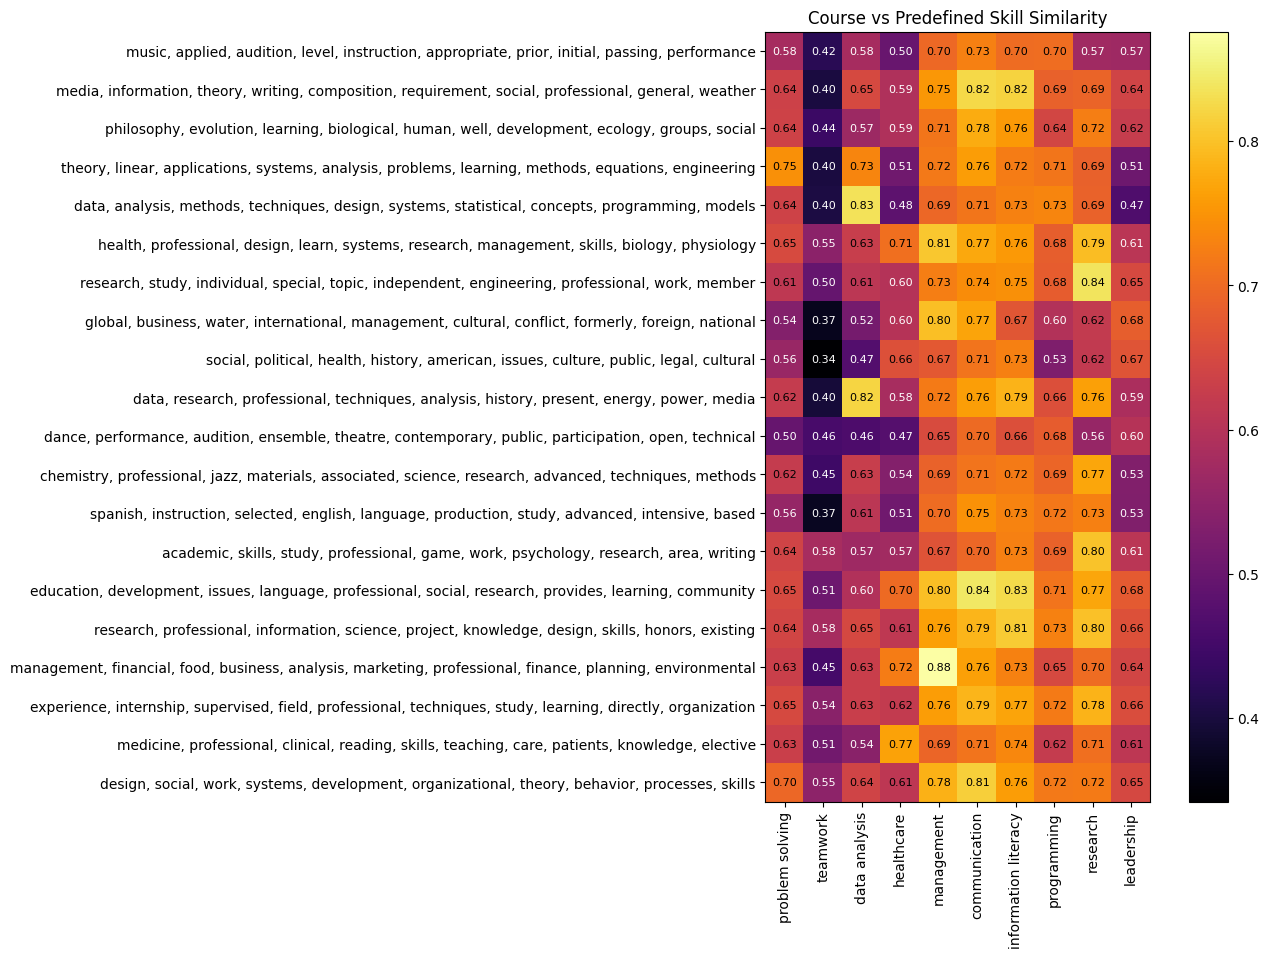

Top 5 Cosine Similarities:
Cosine Similarity: 0.8758253455162048
Course Topic words: management, financial, food, business, analysis, marketing, professional, finance, planning, environmental
Job Topic words: management
Cosine Similarity: 0.84108966588974
Course Topic words: education, development, issues, language, professional, social, research, provides, learning, community
Job Topic words: communication
Cosine Similarity: 0.8379777669906616
Course Topic words: research, study, individual, special, topic, independent, engineering, professional, work, member
Job Topic words: research
Cosine Similarity: 0.8343077301979065
Course Topic words: data, analysis, methods, techniques, design, systems, statistical, concepts, programming, models
Job Topic words: data analysis
Cosine Similarity: 0.8266048431396484
Course Topic words: education, development, issues, language, professional, social, research, provides, learning, community
Job Topic words: information literacy


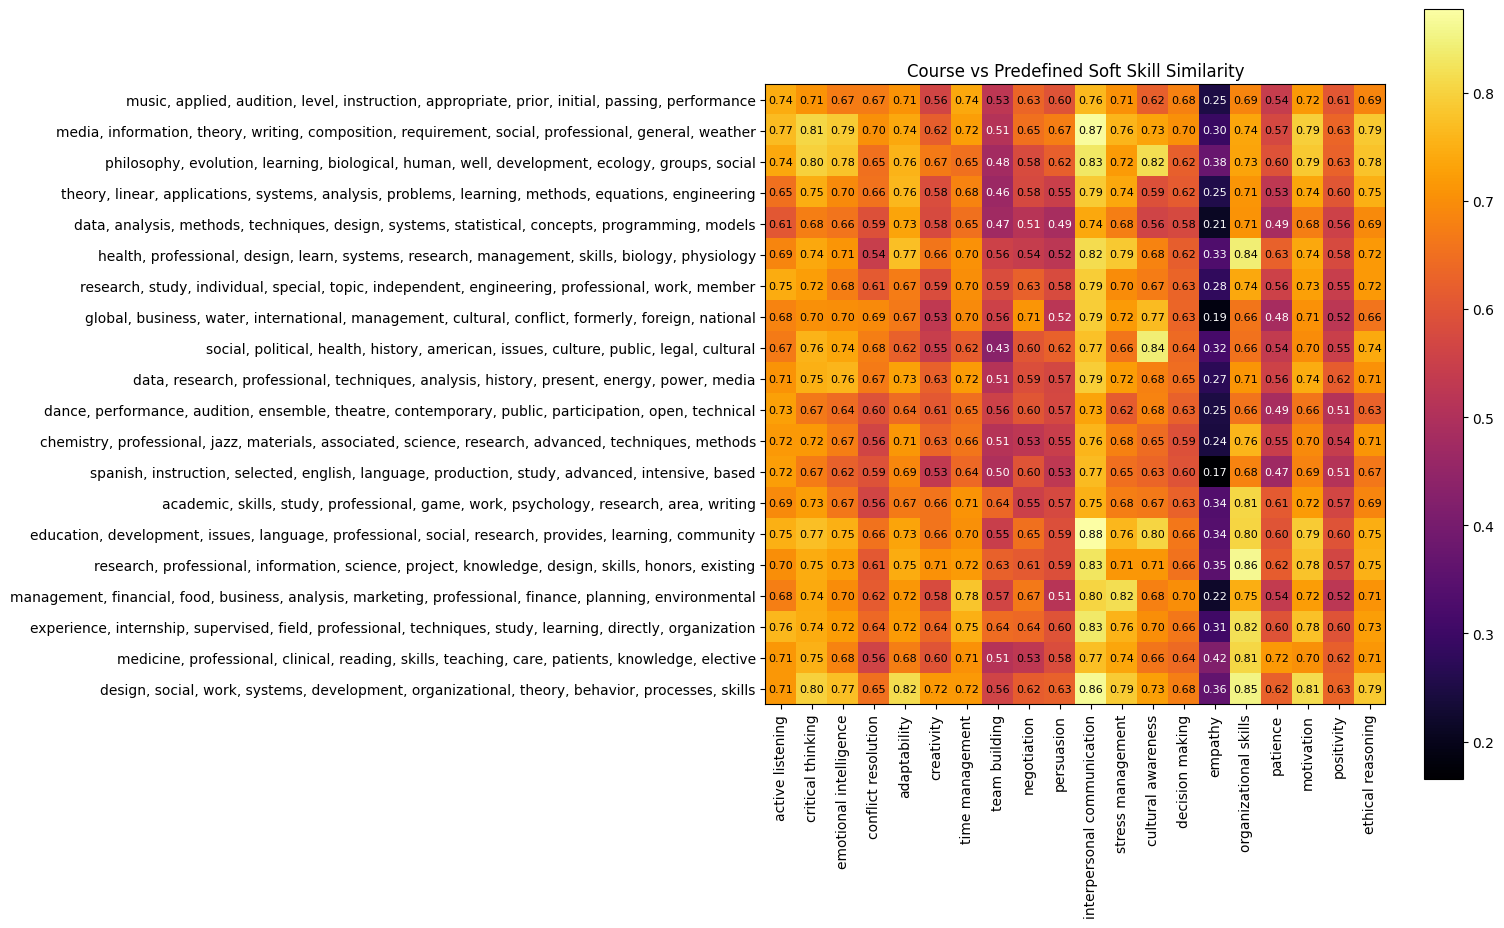

Top 5 Cosine Similarities:
Cosine Similarity: 0.8772719502449036
Course Topic words: education, development, issues, language, professional, social, research, provides, learning, community
Job Topic words: interpersonal communication
Cosine Similarity: 0.8710291385650635
Course Topic words: media, information, theory, writing, composition, requirement, social, professional, general, weather
Job Topic words: interpersonal communication
Cosine Similarity: 0.8648159503936768
Course Topic words: design, social, work, systems, development, organizational, theory, behavior, processes, skills
Job Topic words: interpersonal communication
Cosine Similarity: 0.8613287210464478
Course Topic words: research, professional, information, science, project, knowledge, design, skills, honors, existing
Job Topic words: organizational skills
Cosine Similarity: 0.8543061017990112
Course Topic words: design, social, work, systems, development, organizational, theory, behavior, processes, skills
Job Topic wo

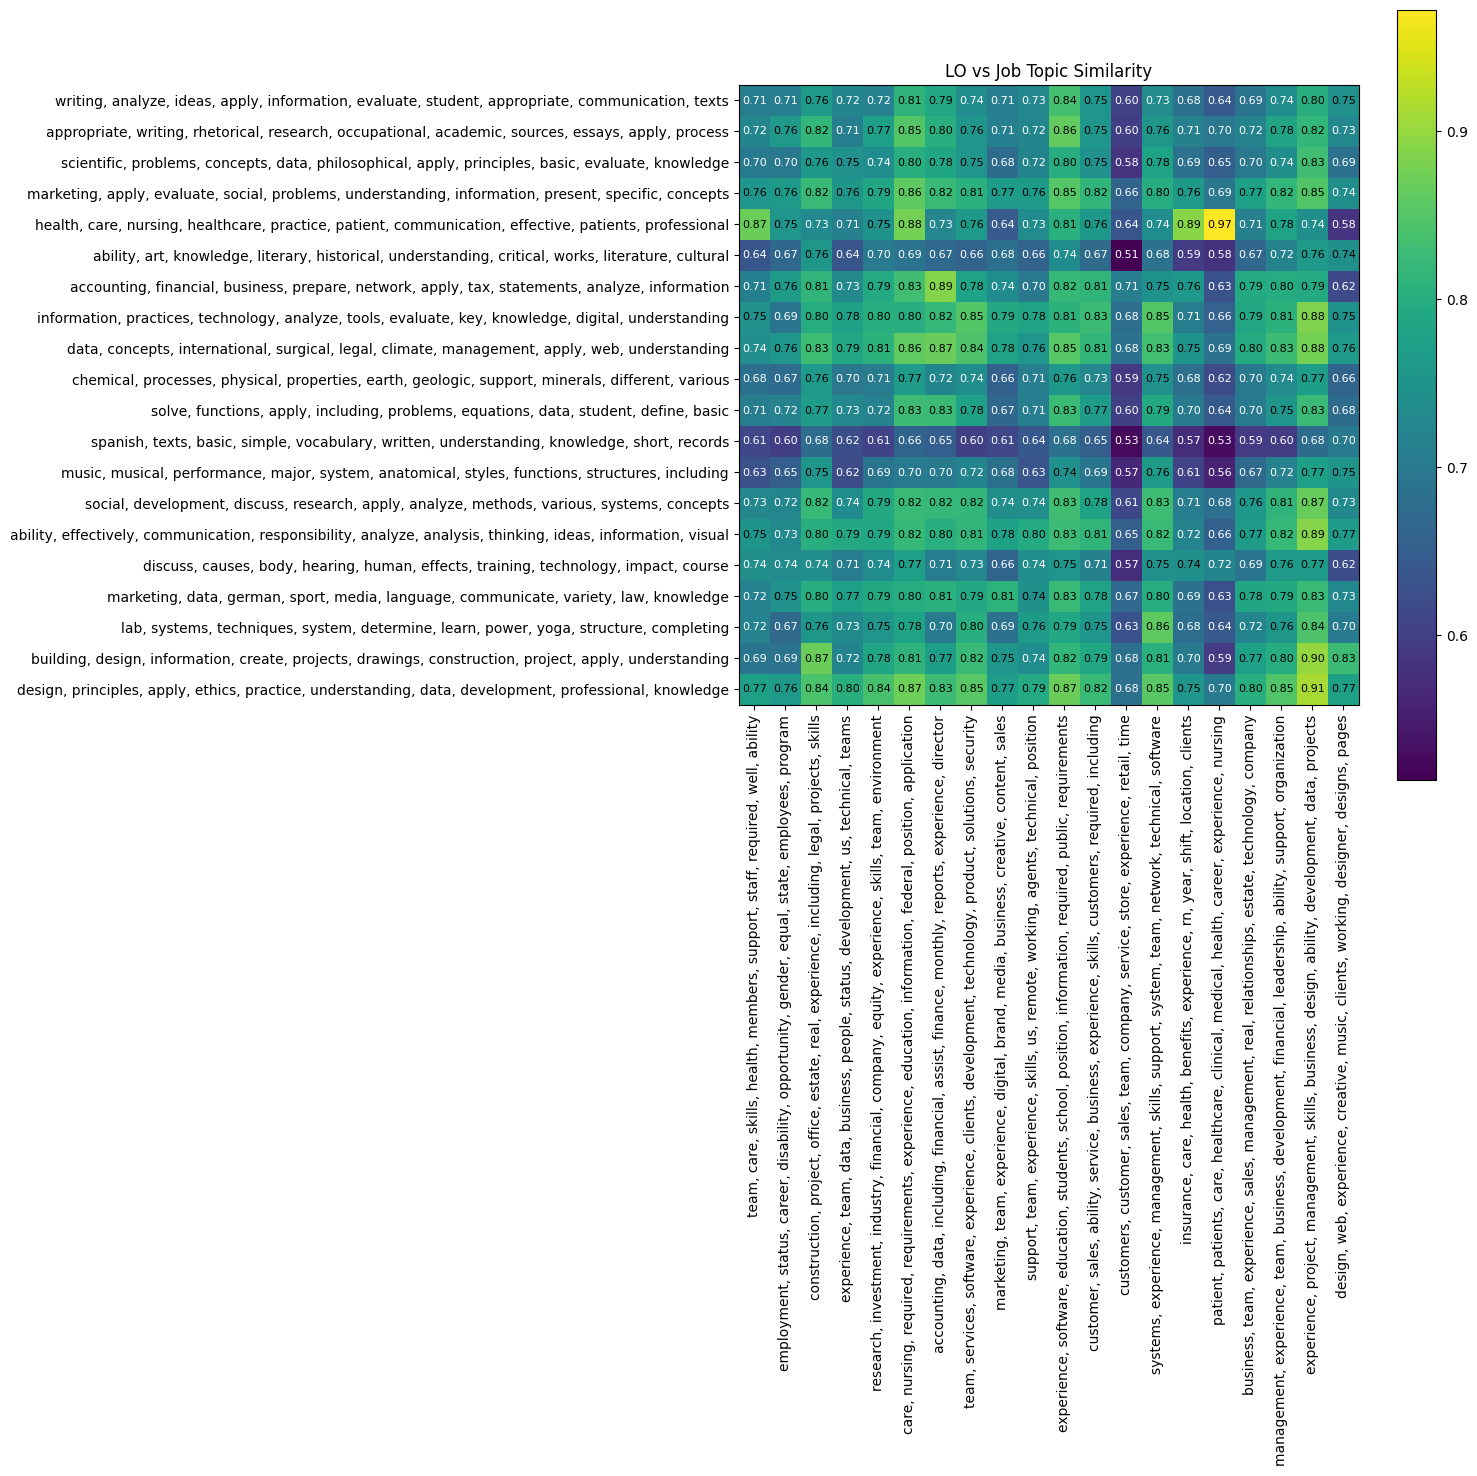

Top 5 Cosine Similarities:
Cosine Similarity: 0.9723237752914429
Course Topic words: health, care, nursing, healthcare, practice, patient, communication, effective, patients, professional
Job Topic words: patient, patients, care, healthcare, clinical, medical, health, career, experience, nursing
Cosine Similarity: 0.912431538105011
Course Topic words: design, principles, apply, ethics, practice, understanding, data, development, professional, knowledge
Job Topic words: experience, project, management, skills, business, design, ability, development, data, projects
Cosine Similarity: 0.8994226455688477
Course Topic words: building, design, information, create, projects, drawings, construction, project, apply, understanding
Job Topic words: experience, project, management, skills, business, design, ability, development, data, projects
Cosine Similarity: 0.8899511098861694
Course Topic words: health, care, nursing, healthcare, practice, patient, communication, effective, patients, professi

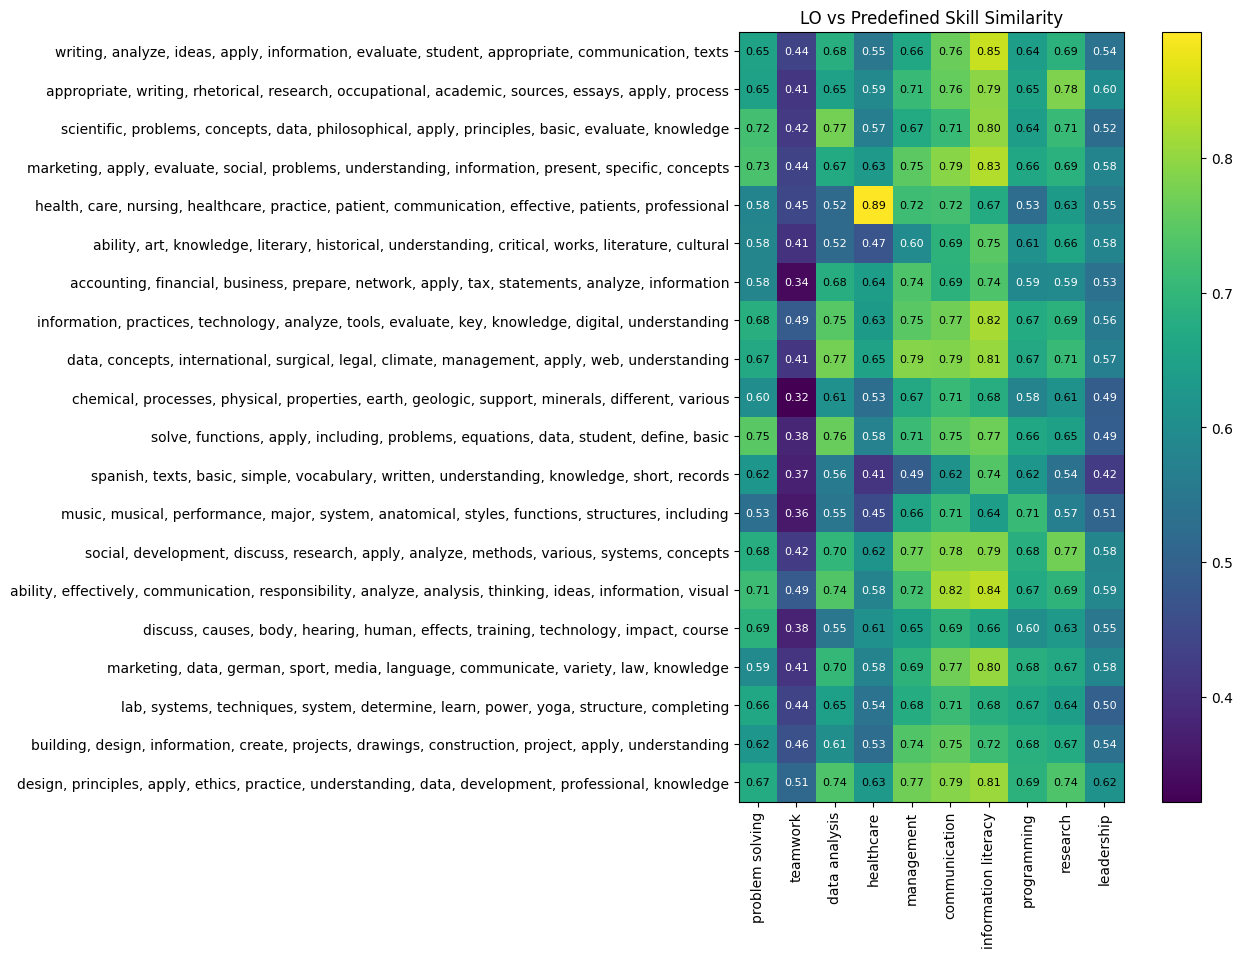

Top 5 Cosine Similarities:
Cosine Similarity: 0.8937237858772278
Course Topic words: health, care, nursing, healthcare, practice, patient, communication, effective, patients, professional
Job Topic words: healthcare
Cosine Similarity: 0.845532238483429
Course Topic words: writing, analyze, ideas, apply, information, evaluate, student, appropriate, communication, texts
Job Topic words: information literacy
Cosine Similarity: 0.8365452289581299
Course Topic words: ability, effectively, communication, responsibility, analyze, analysis, thinking, ideas, information, visual
Job Topic words: information literacy
Cosine Similarity: 0.8269332051277161
Course Topic words: marketing, apply, evaluate, social, problems, understanding, information, present, specific, concepts
Job Topic words: information literacy
Cosine Similarity: 0.8197981715202332
Course Topic words: information, practices, technology, analyze, tools, evaluate, key, knowledge, digital, understanding
Job Topic words: information 

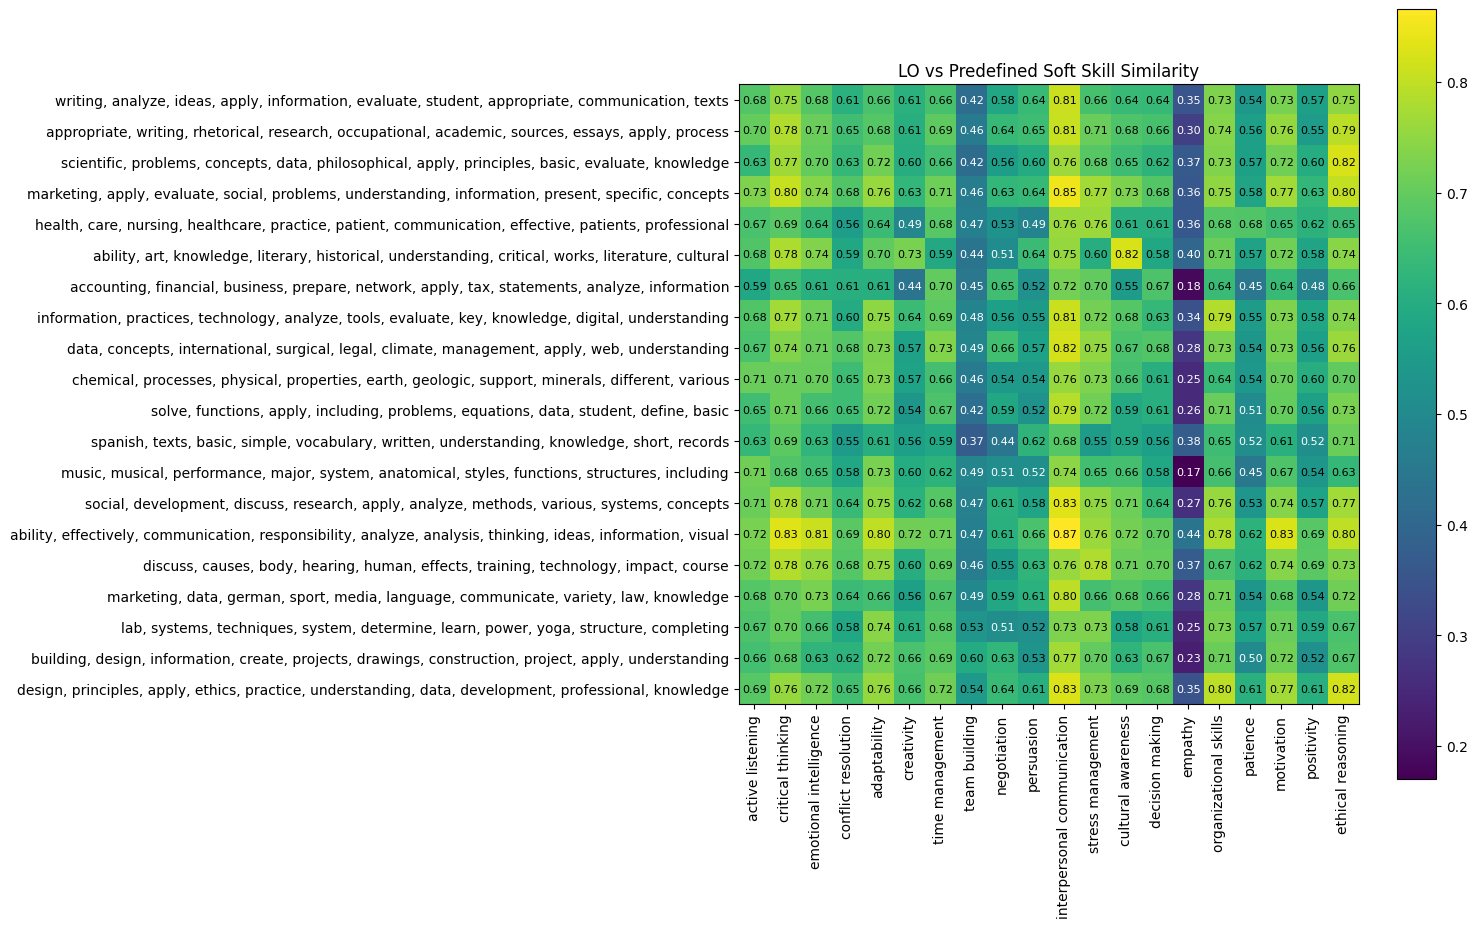

Top 5 Cosine Similarities:
Cosine Similarity: 0.8658491969108582
Course Topic words: ability, effectively, communication, responsibility, analyze, analysis, thinking, ideas, information, visual
Job Topic words: interpersonal communication
Cosine Similarity: 0.8491590023040771
Course Topic words: marketing, apply, evaluate, social, problems, understanding, information, present, specific, concepts
Job Topic words: interpersonal communication
Cosine Similarity: 0.8320087194442749
Course Topic words: social, development, discuss, research, apply, analyze, methods, various, systems, concepts
Job Topic words: interpersonal communication
Cosine Similarity: 0.8316677808761597
Course Topic words: ability, effectively, communication, responsibility, analyze, analysis, thinking, ideas, information, visual
Job Topic words: critical thinking
Cosine Similarity: 0.8288216590881348
Course Topic words: design, principles, apply, ethics, practice, understanding, data, development, professional, knowledg

In [78]:

predefined_skills = ['problem solving', 'teamwork', 'data analysis', 'healthcare', 'management', 'communication', 'information literacy', 'programming', 'research', 'leadership']
predefined_soft_skills = [
    'active listening',
    'critical thinking',
    'emotional intelligence',
    'conflict resolution',
    'adaptability',
    'creativity',
    'time management',
    'team building',
    'negotiation',
    'persuasion',
    'interpersonal communication',
    'stress management',
    'cultural awareness',
    'decision making',
    'empathy',
    'organizational skills',
    'patience',
    'motivation',
    'positivity',
    'ethical reasoning'
]

skill_vectors = [get_average_vector([skill]) for skill in predefined_skills]
soft_skill_vectors = [get_average_vector([skill]) for skill in predefined_soft_skills]


def create_cosine_similarity_heatmap(title, avg_vector1, avg_vector2, labels1, labels2, cmap='inferno'):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    similarities = cosine_similarity(avg_vector1, avg_vector2)

    plt.imshow(similarities, cmap=cmap, interpolation='nearest')

   # Calculate the midpoint of the colormap range
    min_val, max_val = similarities.min(), similarities.max()
    midpoint = (max_val + min_val) / 2.0

    for i in range(similarities.shape[0]):
        for j in range(similarities.shape[1]):
            # Choose text color based on comparison with midpoint
            text_color = 'white' if similarities[i, j] < midpoint else 'black'
            plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center', va='center', fontsize=8, color=text_color)


    plt.yticks(range(len(labels1)), labels1)
    plt.xticks(range(len(labels2)), labels2, rotation=90)
    plt.colorbar()
    plt.show()

    # print the n highest cosine similarities and their corresponding labels
    n = 5
    sorted_similarities = np.sort(similarities, axis=None)[::-1]
    top_n_scores = sorted_similarities[:n]
    print(f'Top {n} Cosine Similarities:')
    for score in top_n_scores:
        print(f'Cosine Similarity: {score}')
        index = np.where(similarities == score)
        print(f'Course Topic words: {labels1[index[0][0]]}')
        print(f'Job Topic words: {labels2[index[1][0]]}')


feature_names_courses = catalog_vectorizer.get_feature_names_out()
top_words_courses = get_topic_keywords(course_lda, feature_names_courses)
average_vector_courses = [get_average_vector(words) for words in top_words_courses]

feature_names_lo = lo_vectorizer.get_feature_names_out()
top_words_lo = get_topic_keywords(lo_lda, feature_names_lo)
average_vector_lo = [get_average_vector(words) for words in top_words_lo]

feature_names_jobs = job_vectorizer.get_feature_names_out()
top_words_jobs = get_topic_keywords(job_lda, feature_names_jobs)
average_vector_jobs = [get_average_vector(words) for words in top_words_jobs]

course_labels = topic_labels(top_words_courses)
lo_labels = topic_labels(top_words_lo)
job_labels = topic_labels(top_words_jobs)

# Compare the similarity between course topics and job topics
create_cosine_similarity_heatmap('Course vs Job Topic Similarity', average_vector_courses, average_vector_jobs, course_labels, job_labels)

# Compare the similarity between course topics and predefined skills
create_cosine_similarity_heatmap('Course vs Predefined Skill Similarity', average_vector_courses, skill_vectors, course_labels, predefined_skills)

# Compare the similarity between course topics and predefined soft skills
create_cosine_similarity_heatmap('Course vs Predefined Soft Skill Similarity', average_vector_courses, soft_skill_vectors, course_labels, predefined_soft_skills)

# Compare the similarity between LO topics and job topics
create_cosine_similarity_heatmap('LO vs Job Topic Similarity', average_vector_lo, average_vector_jobs, lo_labels, job_labels, cmap='viridis')

# Compare the similarity between LO topics and predefined skills
create_cosine_similarity_heatmap('LO vs Predefined Skill Similarity', average_vector_lo, skill_vectors, lo_labels, predefined_skills, cmap='viridis')

# Compare the similarity between LO topics and predefined soft skills
create_cosine_similarity_heatmap('LO vs Predefined Soft Skill Similarity', average_vector_lo, soft_skill_vectors, lo_labels, predefined_soft_skills, cmap='viridis')
